In [12]:
# --- Constants (edit if needed) ---
from pathlib import Path

# Get the directory where this notebook is located
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"

WIDTH = 256
HEIGHT = 256

GT_DIR = DATA_DIR / "gt"  # ground truth masks folder
RGB_DIR = DATA_DIR / "rgb"  # rgb images
GT_NORM_DIR = DATA_DIR / "gt_normalized"  # normalized ground truth masks folder
RGB_NORM_DIR = DATA_DIR / "rgb_normalized"  # normalized rgb images
OUTPUT_JSON = DATA_DIR / "weighted_centers.json"  # output file



In [13]:
# Install and import dependencies
try:
    from PIL import Image
except ImportError:
    print("[Setup] Installing pillow...")
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pillow'])
    from PIL import Image

import numpy as np
import json
from pathlib import Path

In [14]:
# Function to calculate weighted center of a mask
def calculate_weighted_center(mask_path: Path, target_width: int, target_height: int):
    """
    Calculate the weighted center (centroid) of a binary mask.
    
    Args:
        mask_path: Path to the mask image (white = mask, black = background)
        target_width: Target width for normalization
        target_height: Target height for normalization
    
    Returns:
        dict with keys: xo, yo (pixel coords), uo, vo (normalized coords)
    """
    # Load mask as grayscale
    img = Image.open(mask_path).convert('L')
    mask = np.array(img, dtype=np.float32)
    
    # Get original dimensions
    orig_height, orig_width = mask.shape
    
    # Normalize mask values to [0, 1]
    mask = mask / 255.0
    
    # Calculate total weight (sum of all white pixels)
    total_weight = mask.sum()
    
    if total_weight == 0:
        # Empty mask - return center of image
        xo = orig_width / 2.0
        yo = orig_height / 2.0
    else:
        # Create coordinate grids
        y_coords, x_coords = np.mgrid[0:orig_height, 0:orig_width]
        
        # Calculate weighted average
        xo = (x_coords * mask).sum() / total_weight
        yo = (y_coords * mask).sum() / total_weight
    
    # Normalize to UV coordinates (0 to 1)
    uo = xo / orig_width
    vo = yo / orig_height
    
    return {
        "xo": f"{xo:.4f}",
        "yo": f"{yo:.4f}",
        "uo": f"{uo:.4f}",
        "vo": f"{vo:.4f}"
    }


In [15]:
# Function to calculate normalized coordinates after padding
def calculate_normalized_coordinates(xo: float, yo: float, uo: float, vo: float, 
                                     orig_width: int, orig_height: int,
                                     target_width: int, target_height: int):
    """
    Calculate normalized coordinates after resizing with padding.
    
    Args:
        xo, yo: Original pixel coordinates
        uo, vo: Original normalized coordinates (0-1)
        orig_width, orig_height: Original image dimensions
        target_width, target_height: Target dimensions for normalized image
    
    Returns:
        dict with keys: xn, yn (pixel coords in padded image), un, vn (normalized coords in padded image)
    """
    # Calculate aspect ratios
    orig_aspect = orig_width / orig_height
    target_aspect = target_width / target_height
    
    # Determine how image was scaled
    if orig_aspect > target_aspect:
        # Image is wider - scaled to match width, padded vertically
        new_width = target_width
        new_height = int(target_width / orig_aspect)
        paste_x = 0
        paste_y = (target_height - new_height) // 2
    else:
        # Image is taller or equal - scaled to match height, padded horizontally
        new_height = target_height
        new_width = int(target_height * orig_aspect)
        paste_x = (target_width - new_width) // 2
        paste_y = 0
    
    # Scale factor applied to original image
    scale_x = new_width / orig_width
    scale_y = new_height / orig_height
    
    # Calculate pixel coordinates in the resized (but not yet padded) image
    scaled_x = xo * scale_x
    scaled_y = yo * scale_y
    
    # Add padding offset to get coordinates in the final padded image
    xn = scaled_x + paste_x
    yn = scaled_y + paste_y
    
    # Normalize to get un, vn (0-1 coordinates in padded image)
    un = xn / target_width
    vn = yn / target_height
    
    return {
        "xn": f"{xn:.4f}",
        "yn": f"{yn:.4f}",
        "un": f"{un:.4f}",
        "vn": f"{vn:.4f}"
    }


Testing with: 00176.png
Original Center: (301.55, 483.38) pixels
Original Normalized: (0.2356, 0.6714) UV


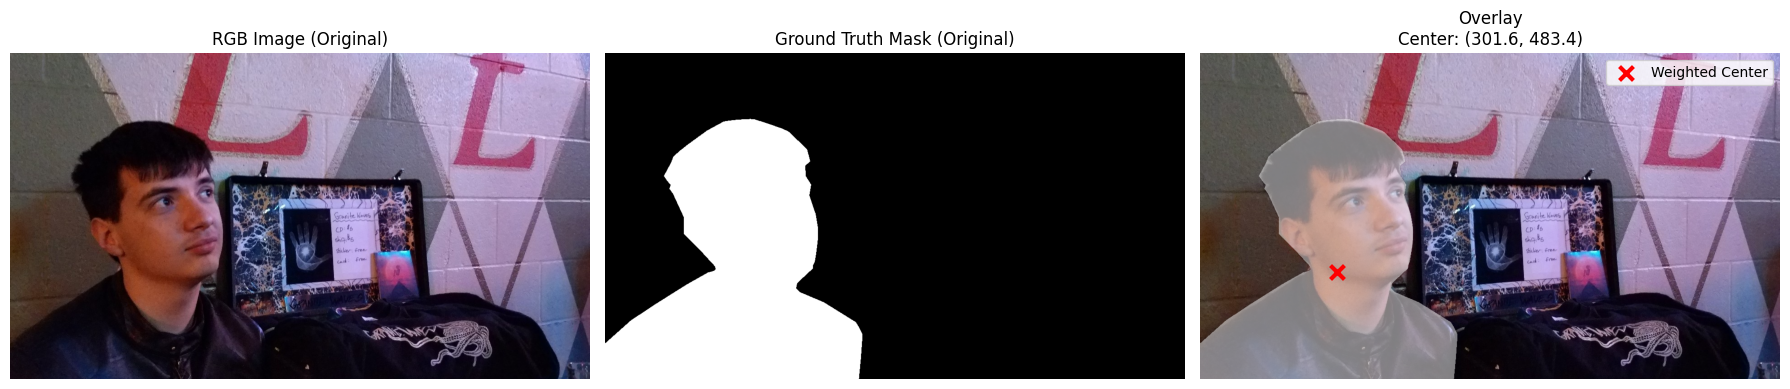

In [22]:
# Test a random entry by loading the JSON, rendering the RGB image, overlaying the GT image at 50%, and marking the weighted center
import random
import matplotlib.pyplot as plt

with open(OUTPUT_JSON, 'r') as f:
    data = json.load(f)

random_file = random.choice(list(data.keys()))
print(f"Testing with: {random_file}")

rgb_image_path = Path(RGB_DIR) / random_file
gt_image_path = Path(GT_DIR) / random_file

# Load images
rgb_image = Image.open(rgb_image_path).convert('RGB')
gt_image = Image.open(gt_image_path).convert('L')  # Grayscale for mask

# Resize GT to match RGB if needed
if gt_image.size != rgb_image.size:
    gt_image = gt_image.resize(rgb_image.size)

# Convert to numpy arrays for blending
rgb_array = np.array(rgb_image)
gt_array = np.array(gt_image)

# Create overlay: blend RGB with semi-transparent white mask
overlay = rgb_array.astype(np.float32).copy()
mask_normalized = gt_array / 255.0
# Blend: 50% RGB + 50% white where mask exists
alpha = 0.5
for c in range(3):
    overlay[:, :, c] = rgb_array[:, :, c] * (1 - alpha * mask_normalized) + 255 * alpha * mask_normalized
overlay = overlay.astype(np.uint8)

# Get weighted center coordinates (original)
center_data = data[random_file]
xo = float(center_data['xo'])
yo = float(center_data['yo'])
uo = float(center_data['uo'])
vo = float(center_data['vo'])

print(f"Original Center: ({xo:.2f}, {yo:.2f}) pixels")
print(f"Original Normalized: ({uo:.4f}, {vo:.4f}) UV")

# Display
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Show RGB image
axes[0].imshow(rgb_array)
axes[0].set_title('RGB Image (Original)')
axes[0].axis('off')

# Show mask
axes[1].imshow(gt_array, cmap='gray')
axes[1].set_title('Ground Truth Mask (Original)')
axes[1].axis('off')

# Show overlay with weighted center
axes[2].imshow(overlay)
axes[2].scatter([xo], [yo], color='red', s=100, marker='x', linewidths=3, label='Weighted Center')
axes[2].set_title(f"Overlay\nCenter: ({xo:.1f}, {yo:.1f})")
axes[2].legend()
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [19]:
# Function to normalize image to target dimensions with padding
def normalize_image_with_padding(image_path: Path, target_width: int, target_height: int, output_path: Path):
    """
    Resize image proportionally to fit within target dimensions and add padding.
    
    Args:
        image_path: Path to input image
        target_width: Target width
        target_height: Target height
        output_path: Path to save normalized image
    
    Returns:
        tuple: (new_img, orig_width, orig_height) - the saved image and original dimensions
    """
    # Load image
    img = Image.open(image_path)

    # Get original dimensions
    orig_width, orig_height = img.size
    
    # Calculate aspect ratios
    orig_aspect = orig_width / orig_height
    target_aspect = target_width / target_height
    
    # Determine scaling to fit within target dimensions
    if orig_aspect > target_aspect:
        # Image is wider - scale to match width, pad vertically
        new_width = target_width
        new_height = int(target_width / orig_aspect)
    else:
        # Image is taller or equal - scale to match height, pad horizontally
        new_height = target_height
        new_width = int(target_height * orig_aspect)
    
    # Resize image proportionally
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    
    # Create new image with target dimensions (black background)
    if img.mode == 'RGB':
        new_img = Image.new('RGB', (target_width, target_height), (0, 0, 0))
    else:
        new_img = Image.new('L', (target_width, target_height), 0)
    
    # Calculate padding to center the resized image
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    
    # Paste resized image onto padded canvas
    new_img.paste(img_resized, (paste_x, paste_y))
    
    # Save
    output_path.parent.mkdir(parents=True, exist_ok=True)
    new_img.save(output_path)
    
    return new_img, orig_width, orig_height


In [20]:
# Process all images: normalize and calculate both original and normalized coordinates
print(f"\n{'='*60}")
print(f"Processing all images to {WIDTH}x{HEIGHT}")
print(f"RGB Input: {RGB_DIR}")
print(f"GT Input: {GT_DIR}")
print(f"RGB Output: {RGB_NORM_DIR}")
print(f"GT Output: {GT_NORM_DIR}")
print(f"{'='*60}\n")

rgb_path = Path(RGB_DIR)
gt_path = Path(GT_DIR)

if not rgb_path.exists():
    raise FileNotFoundError(f"RGB folder not found: {RGB_DIR}")
if not gt_path.exists():
    raise FileNotFoundError(f"GT folder not found: {GT_DIR}")

rgb_files = sorted(rgb_path.glob("*.png"))
print(f"Found {len(rgb_files)} RGB files")

# Dictionary to store all coordinate data
all_results = {}

for i, rgb_file in enumerate(rgb_files):
    try:
        # Find matching GT file
        gt_file = gt_path / rgb_file.name
        if not gt_file.exists():
            print(f"[Warning] No matching GT file for {rgb_file.name}, skipping...")
            continue
        
        # Step 1: Calculate original weighted center from GT mask
        center_data = calculate_weighted_center(gt_file, WIDTH, HEIGHT)
        xo = float(center_data['xo'])
        yo = float(center_data['yo'])
        uo = float(center_data['uo'])
        vo = float(center_data['vo'])
        
        # Step 2: Normalize RGB image and get original dimensions
        rgb_output_path = Path(RGB_NORM_DIR) / rgb_file.name
        _, orig_width, orig_height = normalize_image_with_padding(rgb_file, WIDTH, HEIGHT, rgb_output_path)
        
        # Step 3: Normalize GT image (should have same original dimensions)
        gt_output_path = Path(GT_NORM_DIR) / rgb_file.name
        normalize_image_with_padding(gt_file, WIDTH, HEIGHT, gt_output_path)
        
        # Step 4: Calculate normalized coordinates based on padding transformation
        norm_coords = calculate_normalized_coordinates(
            xo, yo, uo, vo,
            orig_width, orig_height,
            WIDTH, HEIGHT
        )
        
        # Combine all coordinate data
        all_results[rgb_file.name] = {
            **center_data,  # xo, yo, uo, vo
            **norm_coords   # xn, yn, un, vn
        }
        
        if (i + 1) % 50 == 0:
            print(f"[Progress] Processed {i + 1}/{len(rgb_files)} image pairs...")
    except Exception as e:
        print(f"[Error] Failed to process {rgb_file.name}: {e}")
        continue

print(f"\n[Done] Processed {len(all_results)} image pairs")
print(f"RGB saved to: {Path(RGB_NORM_DIR).resolve()}")
print(f"GT saved to: {Path(GT_NORM_DIR).resolve()}")



Processing all images to 256x256
RGB Input: c:\Users\jashim\OneDrive - Microsoft\Desktop\class2025\project\data\rgb
GT Input: c:\Users\jashim\OneDrive - Microsoft\Desktop\class2025\project\data\gt
RGB Output: c:\Users\jashim\OneDrive - Microsoft\Desktop\class2025\project\data\rgb_normalized
GT Output: c:\Users\jashim\OneDrive - Microsoft\Desktop\class2025\project\data\gt_normalized

Found 1000 RGB files
[Progress] Processed 50/1000 image pairs...
[Progress] Processed 100/1000 image pairs...
[Progress] Processed 150/1000 image pairs...
[Progress] Processed 200/1000 image pairs...
[Progress] Processed 250/1000 image pairs...
[Progress] Processed 300/1000 image pairs...
[Progress] Processed 350/1000 image pairs...
[Progress] Processed 400/1000 image pairs...
[Progress] Processed 450/1000 image pairs...
[Progress] Processed 500/1000 image pairs...
[Progress] Processed 550/1000 image pairs...
[Progress] Processed 600/1000 image pairs...
[Progress] Processed 650/1000 image pairs...
[Progres

In [21]:
# Save results to JSON
output_path = Path(OUTPUT_JSON)
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to: {output_path.resolve()}")
print(f"Total entries: {len(all_results)}")

# Show a few examples
if all_results:
    print("\nSample entries:")
    for filename in list(all_results.keys())[:3]:
        entry = all_results[filename]
        print(f"  {filename}:")
        print(f"    Original: xo={entry['xo']}, yo={entry['yo']}, uo={entry['uo']}, vo={entry['vo']}")
        print(f"    Normalized: xn={entry['xn']}, yn={entry['yn']}, un={entry['un']}, vn={entry['vn']}")


Results saved to: C:\Users\jashim\OneDrive - Microsoft\Desktop\class2025\project\data\weighted_centers.json
Total entries: 1000

Sample entries:
  00000.png:
    Original: xo=260.0195, yo=172.8648, uo=0.4063, vo=0.4802
    Normalized: xn=104.0078, yn=125.1459, un=0.4063, vn=0.4889
  00001.png:
    Original: xo=634.6714, yo=408.6008, uo=0.4958, vo=0.5675
    Normalized: xn=126.9343, yn=137.7202, un=0.4958, vn=0.5380
  00002.png:
    Original: xo=145.0998, yo=160.9325, uo=0.2267, vo=0.4470
    Normalized: xn=58.0399, yn=120.3730, un=0.2267, vn=0.4702



Verifying normalization with: 00253.png
Normalized RGB size: (256, 256)
Normalized GT size: (256, 256)
Normalized Center: (131.68, 136.44) pixels
Normalized UV: (0.5144, 0.5330)


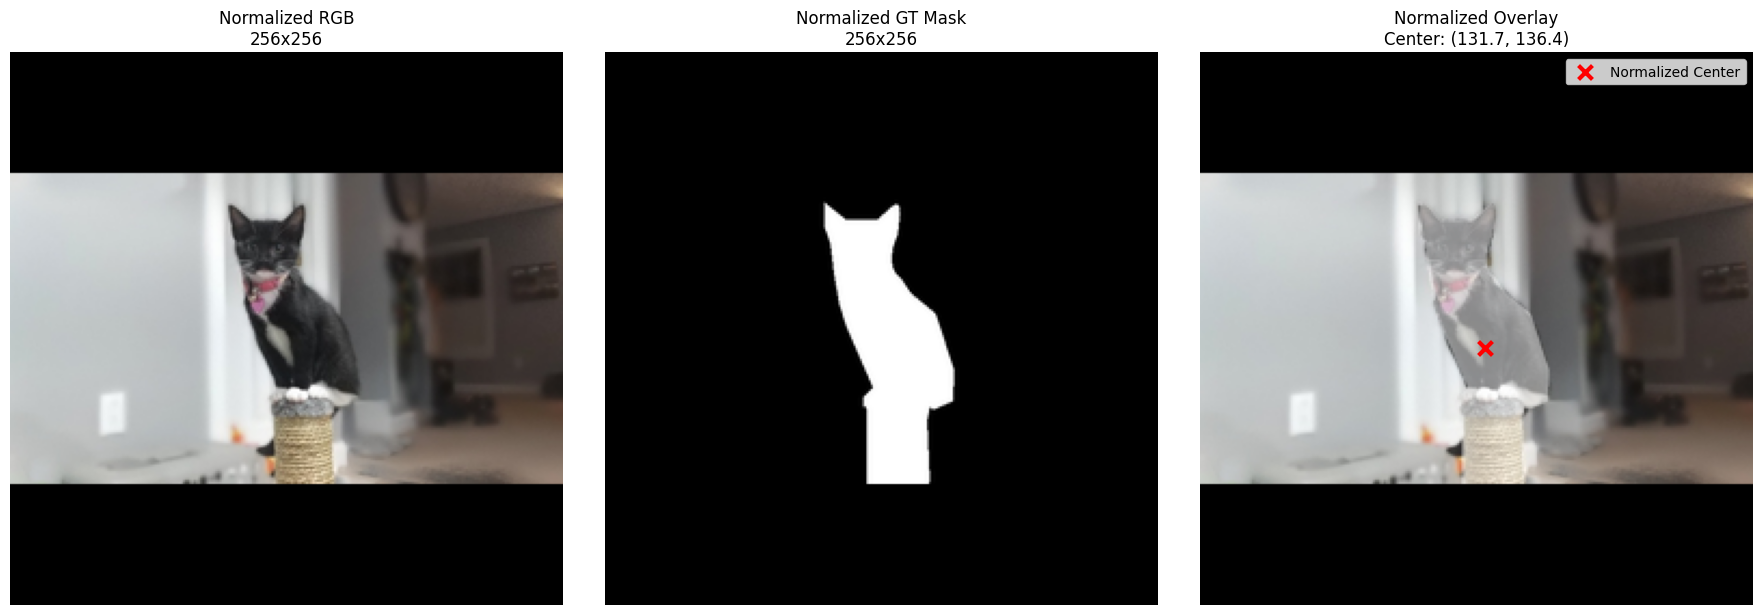

In [ ]:
# Verify normalization by showing a random sample with both original and normalized coordinates
random_file = random.choice(list(data.keys()))
print(f"\nVerifying normalization with: {random_file}")

# Load normalized images
norm_rgb_path = Path(RGB_NORM_DIR) / random_file
norm_gt_path = Path(GT_NORM_DIR) / random_file

if not norm_rgb_path.exists() or not norm_gt_path.exists():
    print(f"[Warning] Normalized images not found. Run the normalization cells above first.")
else:
    norm_rgb = Image.open(norm_rgb_path).convert('RGB')
    norm_gt = Image.open(norm_gt_path).convert('L')
    
    print(f"Normalized RGB size: {norm_rgb.size}")
    print(f"Normalized GT size: {norm_gt.size}")
    
    # Get normalized coordinates
    center_data = data[random_file]
    xn = float(center_data['xn'])
    yn = float(center_data['yn'])
    un = float(center_data['un'])
    vn = float(center_data['vn'])
    
    print(f"Normalized Center: ({xn:.2f}, {yn:.2f}) pixels")
    print(f"Normalized UV: ({un:.4f}, {vn:.4f})")
    
    # Create overlay for normalized image
    norm_rgb_array = np.array(norm_rgb)
    norm_gt_array = np.array(norm_gt)
    
    overlay_norm = norm_rgb_array.astype(np.float32).copy()
    mask_normalized = norm_gt_array / 255.0
    alpha = 0.5
    for c in range(3):
        overlay_norm[:, :, c] = norm_rgb_array[:, :, c] * (1 - alpha * mask_normalized) + 255 * alpha * mask_normalized
    overlay_norm = overlay_norm.astype(np.uint8)
    
    # Display side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(norm_rgb_array)
    axes[0].set_title(f'Normalized RGB\n{norm_rgb.size[0]}x{norm_rgb.size[1]}')
    axes[0].axis('off')
    
    axes[1].imshow(norm_gt_array, cmap='gray')
    axes[1].set_title(f'Normalized GT Mask\n{norm_gt.size[0]}x{norm_gt.size[1]}')
    axes[1].axis('off')
    
    axes[2].imshow(overlay_norm)
    axes[2].scatter([xn], [yn], color='red', s=100, marker='x', linewidths=3, label='Normalized Center')
    axes[2].set_title(f"Normalized Overlay\nCenter: ({xn:.1f}, {yn:.1f})")
    axes[2].legend()
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
